STAT 479: Deep Learning (Spring 2019)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  
Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat479-ss2019/  
GitHub repository: https://github.com/rasbt/stat479-deep-learning-ss19

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p matplotlib,torch,pandas,numpy,PIL

Sebastian Raschka 

CPython 3.6.8
IPython 7.2.0

matplotlib 3.0.2
torch 1.0.0
pandas 0.23.4
numpy 1.15.4
PIL 5.3.0


# STAT479 SS 2019 Deep Learning Competition (Optional)

This is an optional competition that you can participate in to test your deep learning skills! There will be no grade or points for this competition, and participation is entirely voluntary.

**The winner of this competition will receive a $50 Amazon gift card that you can use for whatever you like :). In case of a tie, the earliest submission (latest submission date is Wed, May 01 11:59 pm) with the best score wins.**

You can submit your solution as a single participant or as a group up to 5 students (I will split the amount across the group members then). The winning solution will be the one with the highest test set accuracy. 

You can change anything you like, including the random seed. The only limitation is that you need to make sure that the results are reproducible as I am going to double-check the winning solution by running the code on my computer. If the results on my computer do not match the results you obtained and is lower than the results of the next solution in the list, I will repeat this procedure for the next solution in the list.

You can experiment with your code by exporting it to Python script files. The submitted solution (to Canvas) can be either a Python script file or a Jupyter notebook. However, it has to be a single file that I can run on my computer without installing any additional packages other than the ones I imported above.

Please do not forget to share your solution via the Google Form I will provide as I will use this for ranking the answers. **You can submit your scores as often as you like. However, your final score and code submission must be submitted by Wed, May 01 (11:59 pm)**.


**NOTE: Because of the relatively large size (~250 Mb), you need to obtain the dataset from the following link: https://sebastianraschka.com/share/stat479-ss2019/dl-competition/competition-data.zip** (should have very fast download speed). Download this .zip archive and place it into the same directory as this Jupyter Notebook. Then unzip it. This folder contains ~150,000 images from 5 different classes split into training, validation, and test subsets (CSV files are already included in the .zip archive).

Examples of things you can use and try to use and change are:

- Multilayer Perceptrons
- Convolutional neural networks
- Data normalization
- Image augmentation (random crop, shear, rotation, translation ...)
- Norm penalties, Dropout, BatchNorm
- Different optimization methods
- Learning rate, batch size, ...

Tip: Do not try to cheat by using the test or validation set as additional model fitting data as I am going to run the final solution against my local dataset to reproduce your results. If you altered the dataset, I would notice ;).

## Links

- Link to the submission form: https://docs.google.com/forms/d/e/1FAIpQLSfvw_JNsImfW0fZbQhUsM5XYeLGEUOCcKrN1Zyb1R0wQ0hd7g/viewform?usp=sf_link
- Link to the current ranking updated live (you can only view it if you are logged into UW-Madison's Google platform, it will be private to others so people without a Wisconsin email address will be unable to view the file): https://docs.google.com/spreadsheets/d/11lsz5AT0p6pkYh9Az8ZWxKPD8SleUkq32mv0keIHnEw/edit?usp=sharing

In [2]:
# You should only use the packages already imported below

import torch
import os
import pandas as pd
import numpy as np
import time
from PIL import Image
import torchvision
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# You can modify these two lines
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
# Don't modify the next 2 lines of code. 
# This makes CUDA code reproducible on different machines when using
# convolutions (will explain more in the lecture)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Loading the Dataset

The dataset consists of 5 classes:
- Drawings of "basked" (class 0)
- Drawings of "eye" (class 1)
- Drawings of "binoculars" (class 2)
- Drawings of "rabbit" (class 3)
- Drawings of "hand" (class 4)

(The dataset is based on Google Quickdraw: I wrote a script to fetch the images from the database here: https://quickdraw.withgoogle.com/data)

In [5]:
df_train = pd.read_csv('train.csv')
print('Class distribution Train', np.bincount(df_train['class_label'].values))

Class distribution Train [15000 15000 15000 15000 15000]


In [6]:
df_valid = pd.read_csv('valid.csv')
print('Class distribution Validation', np.bincount(df_valid['class_label'].values))

Class distribution Validation [5000 5000 5000 5000 5000]


In [7]:
df_test = pd.read_csv('test.csv')
print('Class distribution Test', np.bincount(df_test['class_label'].values))

Class distribution Test [10000 10000 10000 10000 10000]


The images are 28x28 dimensional (grayscale).

Some examples:

png-files/binoculars/binoculars_000018.png


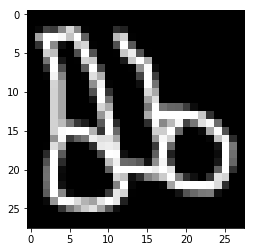

png-files/binoculars/binoculars_000037.png


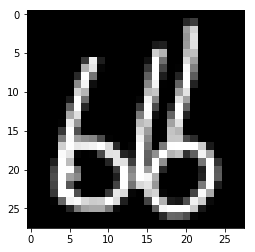

png-files/binoculars/binoculars_046497.png


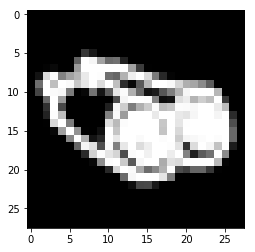

In [8]:
import glob
image_paths = sorted(glob.glob('png-files/binoculars/*.png'))
for i in (12, 25, 30000):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()

png-files/hand/hand_000056.png


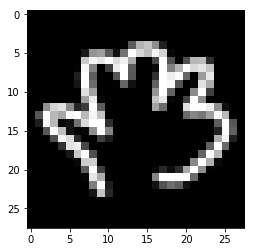

png-files/hand/hand_000110.png


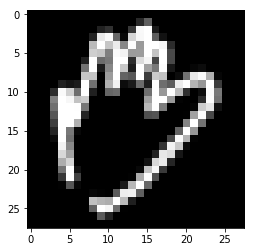

png-files/hand/hand_109395.png


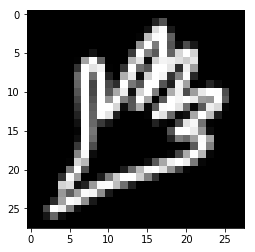

In [9]:
image_paths = sorted(glob.glob('png-files/hand/*.png'))
for i in (12, 25, 30000):
    im_path = image_paths[i]
    print(im_path)
    im = Image.open(im_path)
    plt.imshow(im)
    plt.show()

In [10]:
class QuickdrawDataset(Dataset):
    """Custom Dataset for loading Quickdraw images"""

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.img_names = df['relative_path'].values
        self.y = df['class_label'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [11]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])


train_dataset = QuickdrawDataset(csv_path='train.csv',
                                 img_dir='png-files/',
                                 transform=custom_transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128, #### CHANGE IF YOU LIKE
                          shuffle=True,
                          num_workers=4)


valid_dataset = QuickdrawDataset(csv_path='valid.csv',
                                 img_dir='png-files/',
                                 transform=custom_transform)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=4)

test_dataset = QuickdrawDataset(csv_path='test.csv',
                                img_dir='png-files/',
                                transform=custom_transform)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=128,
                         shuffle=False,
                         num_workers=4)

The cell below just checks if the dataset can be loaded correctly.

In [12]:
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        print('Image shape', x.shape)
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        print('break minibatch for-loop')
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Image shape torch.Size([128, 1, 28, 28])
break minibatch for-loop
Epoch: 2 | Batch index: 0 | Batch size: 128
Image shape torch.Size([128, 1, 28, 28])
break minibatch for-loop


# Multilayer Perceptron Model

The cell below contains the multi-layer perceptron model. This is the main section where you want to make changes to the architecture.

In [13]:
class MLP(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1,num_classes):
        super(MLP, self).__init__()
        
        self.num_classes = num_classes
    
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        self.linear_out = torch.nn.Linear(num_hidden_1, num_classes)
        
    def forward(self, x):

        out = self.linear_1(x)
        out = torch.sigmoid(out)
        
        logits = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

    
#################################
### Model Initialization
#################################


torch.manual_seed(RANDOM_SEED)

model = MLP(num_features=28*28,
            num_hidden_1=50,
            num_classes=5)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

In [14]:
#################################
### Training
#################################


def compute_epoch_loss(model, data_loader):
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


################################################
# PLEASE DON'T CHANGE THE compute_accuracy
# function
###############################################
    
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.view(-1, 28*28).to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model.forward(features)
            predicted_labels = torch.argmax(probas, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
        return correct_pred.float()/num_examples * 100
    


start_time = time.time()
minibatch_cost = []
epoch_cost = []


NUM_EPOCHS = 25

for epoch in range(NUM_EPOCHS):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        minibatch_cost.append(cost)
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))
        
    model.eval()
    cost = compute_epoch_loss(model, train_loader)
    epoch_cost.append(cost)
    
    train_accuracy = compute_accuracy(model, train_loader)
    valid_accuracy = compute_accuracy(model, valid_loader)
    
    print('Epoch: %03d/%03d Train Cost: %.4f' % (
            epoch+1, NUM_EPOCHS, cost))
    print('Train Accuracy: %.3f | Validation Accuracy: %.3f' % (train_accuracy, valid_accuracy))
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/025 | Batch 000/586 | Cost: 1.6200
Epoch: 001/025 | Batch 050/586 | Cost: 1.5622
Epoch: 001/025 | Batch 100/586 | Cost: 1.5071
Epoch: 001/025 | Batch 150/586 | Cost: 1.4469
Epoch: 001/025 | Batch 200/586 | Cost: 1.3490
Epoch: 001/025 | Batch 250/586 | Cost: 1.2703
Epoch: 001/025 | Batch 300/586 | Cost: 1.2051
Epoch: 001/025 | Batch 350/586 | Cost: 1.0768
Epoch: 001/025 | Batch 400/586 | Cost: 1.0429
Epoch: 001/025 | Batch 450/586 | Cost: 1.0361
Epoch: 001/025 | Batch 500/586 | Cost: 0.9238
Epoch: 001/025 | Batch 550/586 | Cost: 0.8900
Epoch: 001/025 Train Cost: 0.9083
Train Accuracy: 69.645 | Validation Accuracy: 69.916
Time elapsed: 0.25 min
Epoch: 002/025 | Batch 000/586 | Cost: 0.9584
Epoch: 002/025 | Batch 050/586 | Cost: 0.8522
Epoch: 002/025 | Batch 100/586 | Cost: 0.8944
Epoch: 002/025 | Batch 150/586 | Cost: 0.8053
Epoch: 002/025 | Batch 200/586 | Cost: 0.8360
Epoch: 002/025 | Batch 250/586 | Cost: 0.8669
Epoch: 002/025 | Batch 300/586 | Cost: 0.8938
Epoch: 002/025 |

# Evaluation (No Need To Change Any Code in This Section!)

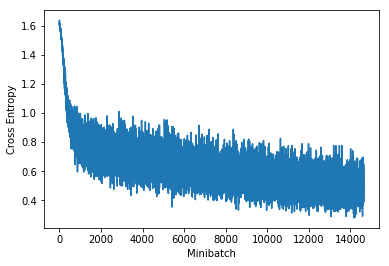

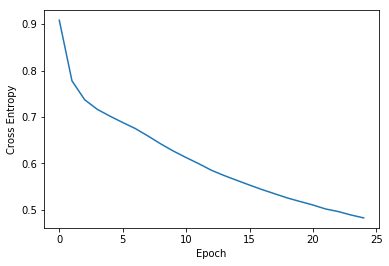

In [15]:
plt.plot(range(len(minibatch_cost)), minibatch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Minibatch')
plt.show()

plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [16]:
print('Test Accuracy: %.2f' % compute_accuracy(model, test_loader))

Test Accuracy: 84.13


# Answer Required

Summarize your final architecture and settings in a short paragraph.